In [963]:
%matplotlib inline
import matplotlib.pyplot as plt
from lightjob.cli import load_db
from lightjob.db import SUCCESS
import collections
import json
import pandas as pd
import numpy as np
from tpot import TPOTClassifier, TPOTRegressor
from xgboost import XGBRegressor
from IPython.display import Image
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import KFold, train_test_split, ShuffleSplit
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
def flatten_dict(l):
    d = {}
    for k, v in l.items():
        if isinstance(v, collections.Mapping):
            d.update(flatten_dict(v))
        elif isinstance(v, list) or isinstance(v, tuple):
            for i, l in enumerate(v):
                d[k+'_{}'.format(i)] = l
        else:
            d[k] = v
    return d
def plot_imp(names, values):
    ind = (np.arange(len(names)))
    plt.xticks(ind + 0.5, names)
    plt.bar(ind, values, width=1)
    plt.xlabel('variable index')
    plt.ylabel('importance')

class EnsembleRegressor(object):
    def __init__(self, regs=None):
        self.regs = regs

    def fit(self, X, y):
        return self

    def predict(self, X, return_std=False):
        if return_std:
            means = []
            stds = []
            for r in self.regs:
                m, s = r.predict(X, return_std=True)
                means.append(m)
                stds.append(s)
            means = np.vstack(means).T
            stds = np.vstack(stds).T
            return np.mean(means, axis=1), (np.sqrt((stds**2).sum(axis=1)) / stds.shape[1])
        else:
            preds = np.vstack([r.predict(X) for r in self.regs]).T
            return np.mean(preds, axis=1)


In [53]:
db = load_db(folder='../../feature_generation/.lightjob')

In [54]:
jobs = list(db.jobs_with(state=SUCCESS, type='training'))
jobs = filter(lambda j:j['content']['dataset'] == 'digits', jobs)

In [58]:
for j in jobs:
    print(j['stats']['training']['avg_loss_train_details'])
    break

{u'50per': 54.85158047638317, u'90per': 53.820155732562135, u'5per': 55.28937117287276, u'70per': 54.51151175866086, u'30per': 54.312614499544196, u'10per': 54.41327650537736}


In [714]:
df = pd.DataFrame()
df['hypers'] = [j['content'] for j in jobs]
cst = 784.
def get_details(name, subname, j):
    if name + '_details' in j['stats']['training']:
        return j['stats']['training']['avg_loss_train_fix_details'][subname] / cst
    else:
        return np.nan
    
earlys = ('5per', '10per', '30per', '50per', '70per', '90per')
for k in earlys:
    df['avg_loss_train_early_'  + k] = [get_details('avg_loss_train_fix', k, j)  for j in jobs]
df['avg_loss_train'] = [j['stats']['training'].get('avg_loss_train_fix', np.nan) / cst  for j in jobs]
df['jobset'] = [j['where'] for j in jobs]

In [1163]:
colnames = set()
for i in range(len(df)):
    h = df['hypers'].iloc[i]
    h = flatten_dict(h)
    colnames |= set(h.keys())
colnames = list(colnames)
for col in colnames:
    df[col] = df.apply(lambda r:flatten_dict((r['hypers'])).get(col), axis=1)
df = df.dropna(axis=0, subset=['avg_loss_train'])
for k in earlys:
    df = df.dropna(axis=0, subset=['avg_loss_train_early_' + k])

In [1164]:
cols = ['avg_loss_train_early_' + k for k in earlys[0:2]]
cols += colnames
df_x = df[cols]
df_x = df_x.fillna(-1)
df_x = pd.get_dummies(df_x)
df_y = df['avg_loss_train']
df_y_rel = (df[cols[1]] - df['avg_loss_train']) / (df['avg_loss_train'])

In [1165]:
X_vect = df_x.values
y_vect = df_y.values
cols = (df_x.columns.values)

In [1174]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y_vect, test_size=0.2)

In [1175]:
from sklearn.base import clone

kernel = RBF()
#reg = Ridge(alpha=10)
#reg = LinearRegression()
#reg = RandomForestRegressor(n_estimators=10, max_depth=10)
#reg = DecisionTreeRegressor(max_depth=10, random_state=1)
reg = GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=10)
scores = []
#for train, test in StratifiedShuffleSplit(y, n_iter=10, test_size=0.9, random_state=2):

reg_orig = clone(reg)

def S(reg, x, y):
    return np.abs(reg.predict(x) - y).mean()
    #return (np.abs(reg.predict(x) - y)/(y)).mean()
print('train    valid')
regs = []

#for train, test in ShuffleSplit(len(X_train), n_iter=10, test_size=0.2, random_state=2):
for train, test in KFold(len(X_train), n_folds=5, shuffle=True, random_state=2):
    reg = clone(reg_orig)
    reg.fit(X_train[train], y_train[train])
    print('{:.5f} {:.5f}'.format(S(reg, X_train[train], y_train[train]), S(reg, X_train[test], y_train[test])))
    score = S(reg, X_train[test], y_train[test])
    scores.append(score)
    regs.append(reg)
print('mean valid:')
print(np.mean(scores), np.std(scores))

train    valid
0.00002 0.01458
0.00003 0.01562
0.00002 0.01616
0.00002 0.02224
0.00002 0.01696
mean valid:
(0.017111805008981053, 0.0026770201754822841)


In [1176]:
final_reg = EnsembleRegressor(regs)
for r in regs:
    print(S(r, X_test, y_test))
print('ens:')
print(S(final_reg, X_test, y_test))
m, s = final_reg.predict(X_test, return_std=True)
mr, sr = reg.predict(X_test, return_std=True)

0.019602538512
0.0184645382486
0.0198696382999
0.0198764950415
0.0197055769261
ens:
0.0184561957645


In [1177]:
print('ens std avg:', np.sqrt((s**2).sum()/(len(s)**2)))
print('one std avg:', np.sqrt((sr**2).sum()/(len(sr)**2)))

('ens std avg:', 0.013815792103271303)
('one std avg:', 0.031177241022441026)


In [1178]:
pd.DataFrame({'pred': m*784, 'std': s*784,  'std_r':sr*784, 'real': y_test * 784}).sample(30)

,pred,real,std,std_r
164,27.443498,27.066899,0.789217,1.795550
84,33.526726,37.081855,350.615459,784.000000
226,33.526726,181.341622,350.615459,784.000000
298,25.869163,20.945761,280.891483,769.643695
251,4.988914,4.994250,0.698043,0.000000
275,62.045741,124.905732,335.025016,741.576849
234,29.712356,22.297878,344.474767,776.742800
271,33.526726,61.595313,350.615459,784.000000
29,0.454950,0.388156,0.235595,0.537132
286,11.772700,11.765984,0.822388,0.000000


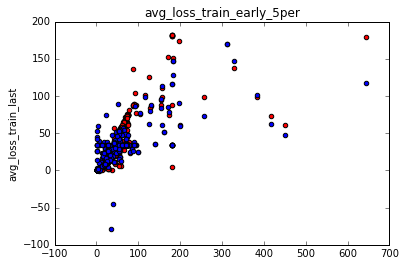

In [1179]:
plt.scatter(X_test[:, 0]*cst, y_test*cst, c='r')
plt.scatter(X_test[:, 0]*cst, final_reg.predict(X_test)*cst, c='b')
plt.title(cols[0])
plt.ylabel('avg_loss_train_last')

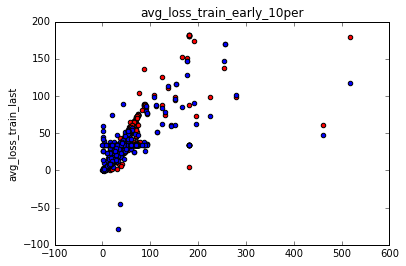

In [1183]:
plt.scatter(X_test[:, 1]*cst, y_test*cst, c='r')
plt.scatter(X_test[:, 1]*cst, final_reg.predict(X_test)*cst, c='b')
plt.title(cols[1])
plt.ylabel('avg_loss_train_last')

In [1182]:
print((s>sr).mean())

0.220657276995
